Starting Strategy Comparison Script...
(3019, 93)
Loaded price relative vectors CSV in 0.0651 seconds.
Initialized portfolio in 0.0001 seconds.

Running strategy: Buy and Hold
    Final wealth = 9.1742, Exponential growth = 0.0007, Sharpe = 0.5797
    Strategy 'Buy and Hold' completed in 0.0173 seconds.

Running strategy: Best Stock
    Final wealth = 0.0153, Exponential growth = -0.0014, Sharpe = 0.0905
    Strategy 'Best Stock' completed in 0.0084 seconds.

Running strategy: Constant Rebalancing
    Final wealth = 12.1584, Exponential growth = 0.0008, Sharpe = 0.7553
    Strategy 'Constant Rebalancing' completed in 0.0038 seconds.

Running strategy: Aggregation-Based Generalized
    Final wealth = 12.1570, Exponential growth = 0.0008, Sharpe = 0.7552
    Strategy 'Aggregation-Based Generalized' completed in 0.0434 seconds.

Running strategy: Fast Universalization
    Final wealth = 101.7371, Exponential growth = 0.0015, Sharpe = 1.3490
    Strategy 'Fast Universalization' completed i

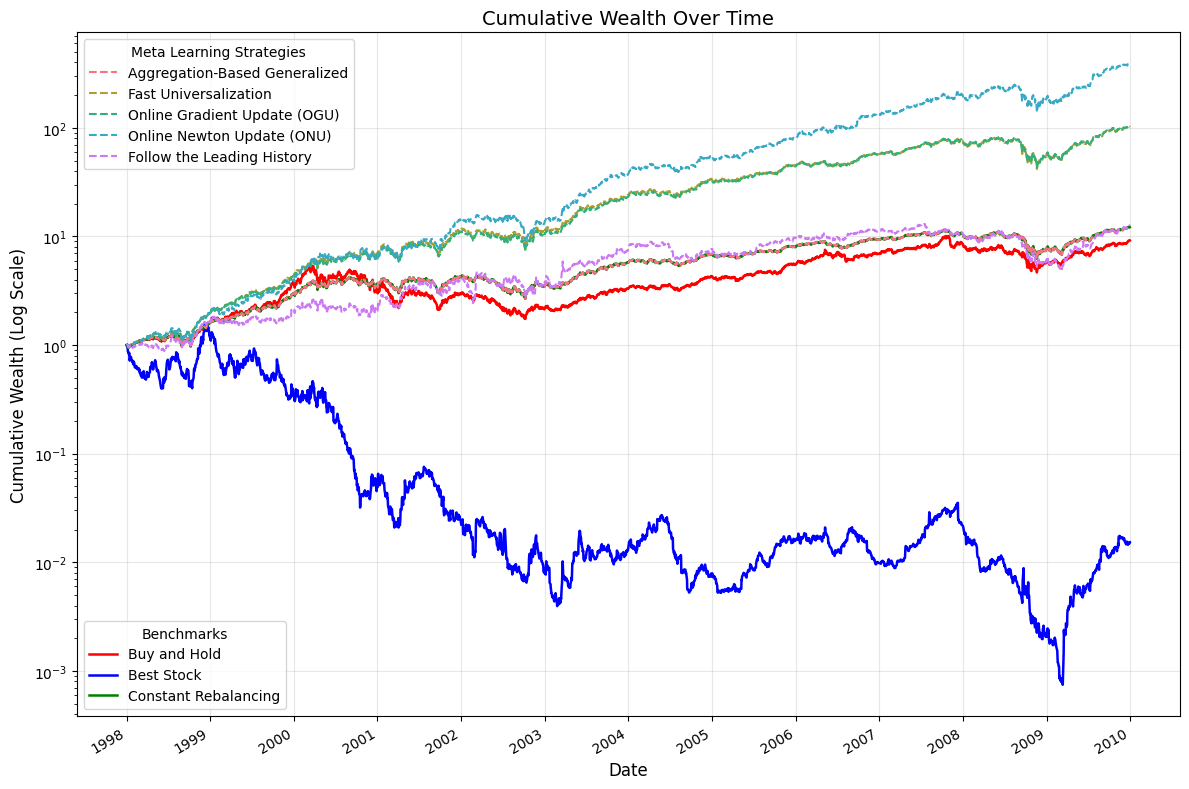

Plot generated in 1.4273 seconds.

===== Final Sharpe Ratios (Sorted) =====
Online Newton Update (ONU): 1.5562
Online Gradient Update (OGU): 1.3648
Fast Universalization: 1.3490
Constant Rebalancing: 0.7553
Aggregation-Based Generalized: 0.7552
Follow the Leading History: 0.6134
Buy and Hold: 0.5797
Best Stock: 0.0905

Total execution time: 8652.5989 seconds.


In [2]:
# ---------------------------------
# Meta Learning Strategy Comparison
# ---------------------------------

import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys

# Utility Function Imports (only import those needed)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utilities import (initialize_portfolio, calculate_cumulative_wealth_over_time, 
                       calculate_exponential_growth_rate, compute_periodic_returns, 
                       compute_sharpe_ratio)

# Algorithm Imports
from Strategies.benchmarks import *
from Strategies.meta_learning import *

# Start total timer
total_start = time.time()
print("Starting Strategy Comparison Script...")

# --------------------------
# Data Loading & Initialization
# --------------------------
start_csv = time.time()
price_relative_df = pd.read_csv("../../Data/Price Relative Vectors/price_relative_vectors.csv", index_col=0)
print(price_relative_df.shape)
end_csv = time.time()
print(f"Loaded price relative vectors CSV in {end_csv - start_csv:.4f} seconds.")

start_portfolio = time.time()
b = initialize_portfolio(price_relative_df.shape[1])
end_portfolio = time.time()
print(f"Initialized portfolio in {end_portfolio - start_portfolio:.4f} seconds.")

# Build price relative vectors and dates
price_relative_vectors_array = price_relative_df.values
dates = pd.to_datetime(price_relative_df.index)

# --------------------------
# Strategy Definitions
# --------------------------
benchmarks = {
    'Buy and Hold': buy_and_hold,
    'Best Stock': best_stock,
    'Constant Rebalancing': constant_rebalancing
}

meta_learning_strategies = {
    "Aggregation-Based Generalized": aggregation_algorithm_generalized,
    "Fast Universalization": fast_universalization,
    "Online Gradient Update (OGU)": online_gradient_update_meta,
    "Online Newton Update (ONU)": online_newton_update_meta,
    "Follow the Leading History": follow_the_leading_history
}

# Combine all strategies
all_strategies = {**benchmarks, **meta_learning_strategies}

# Pre-allocate dictionaries for results
cumulative_wealth_dict = {}
sharpe_dict = {}

# --------------------------
# Run Strategies
# --------------------------
strategies_start = time.time()
for strategy_name, strategy_function in all_strategies.items():
    print(f"\nRunning strategy: {strategy_name}")
    strat_start = time.time()
    try:
        # Compute portfolio weight vectors for each period
        b_n_strat = strategy_function(b, price_relative_vectors_array)
        
        # Compute cumulative wealth over time
        cum_wealth = calculate_cumulative_wealth_over_time(b_n_strat, price_relative_vectors_array)
        cumulative_wealth_dict[strategy_name] = cum_wealth

        # Calculate exponential growth rate
        final_wealth = cum_wealth[-1]
        n_periods = len(price_relative_vectors_array)
        exp_growth = calculate_exponential_growth_rate(final_wealth, n_periods)

        # Calculate daily returns and Sharpe ratio
        daily_returns = compute_periodic_returns(cum_wealth)
        sr = compute_sharpe_ratio(daily_returns, freq=252, risk_free_rate=0.05)
        sharpe_dict[strategy_name] = sr

        strat_end = time.time()
        print(f"    Final wealth = {final_wealth:.4f}, Exponential growth = {exp_growth:.4f}, Sharpe = {sr:.4f}")
        print(f"    Strategy '{strategy_name}' completed in {strat_end - strat_start:.4f} seconds.")
    except Exception as e:
        print(f"Error in strategy '{strategy_name}': {e}")
strategies_end = time.time()
print(f"\nAll strategies completed in {strategies_end - strategies_start:.4f} seconds.")

# --------------------------
# Plot Results
# --------------------------
plot_start = time.time()

# Define explicit colors for benchmarks
benchmark_colors = ['red', 'blue', 'green']
meta_learning_colors = sns.color_palette("husl", n_colors=len(meta_learning_strategies))

fig, ax = plt.subplots(figsize=(12, 8))

# Plot Benchmarks (solid lines)
bench_handles, bench_labels = [], []
for (strategy_name, color) in zip(benchmarks.keys(), benchmark_colors):
    line, = ax.plot(
        dates,
        cumulative_wealth_dict[strategy_name],
        label=strategy_name,
        color=color,
        linewidth=1.8
    )
    bench_handles.append(line)
    bench_labels.append(strategy_name)

# Plot Meta Learning Strategies (dashed lines)
ml_handles, ml_labels = [], []
for (strategy_name, color) in zip(meta_learning_strategies.keys(), meta_learning_colors):
    line, = ax.plot(
        dates,
        cumulative_wealth_dict[strategy_name],
        label=strategy_name,
        color=color,
        linewidth=1.5,
        linestyle='--'
    )
    ml_handles.append(line)
    ml_labels.append(strategy_name)

# Customize axis and grid
ax.set_title('Cumulative Wealth Over Time', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Wealth (Log Scale)', fontsize=12)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Set x-axis to show yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()

# Create two separate legends
ml_legend = ax.legend(ml_handles, ml_labels, title='Meta Learning Strategies', loc='upper left')
ax.add_artist(ml_legend)  # Add the Meta Learning legend first
bench_legend = ax.legend(bench_handles, bench_labels, title='Benchmarks', loc='lower left')

plt.tight_layout()
plt.show()

plot_end = time.time()
print(f"Plot generated in {plot_end - plot_start:.4f} seconds.")

# --------------------------
# Final Results: Sharpe Ratios
# --------------------------
print("\n===== Final Sharpe Ratios (Sorted) =====")
sorted_sharpe = sorted(sharpe_dict.items(), key=lambda x: x[1], reverse=True)
for strat_name, sr_val in sorted_sharpe:
    print(f"{strat_name}: {sr_val:.4f}")

total_end = time.time()
print(f"\nTotal execution time: {total_end - total_start:.4f} seconds.")